In [44]:
import numpy as np 
import pandas as pd 
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/netflix-shows/netflix_titles.csv


**Loading in the data**

In [45]:
df = pd.read_csv("../input/netflix-shows/netflix_titles.csv")

In [46]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [47]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [48]:
df.shape

(8807, 12)

In [49]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

Text(0.5, 1.0, 'Movies vs Shows Time Series')

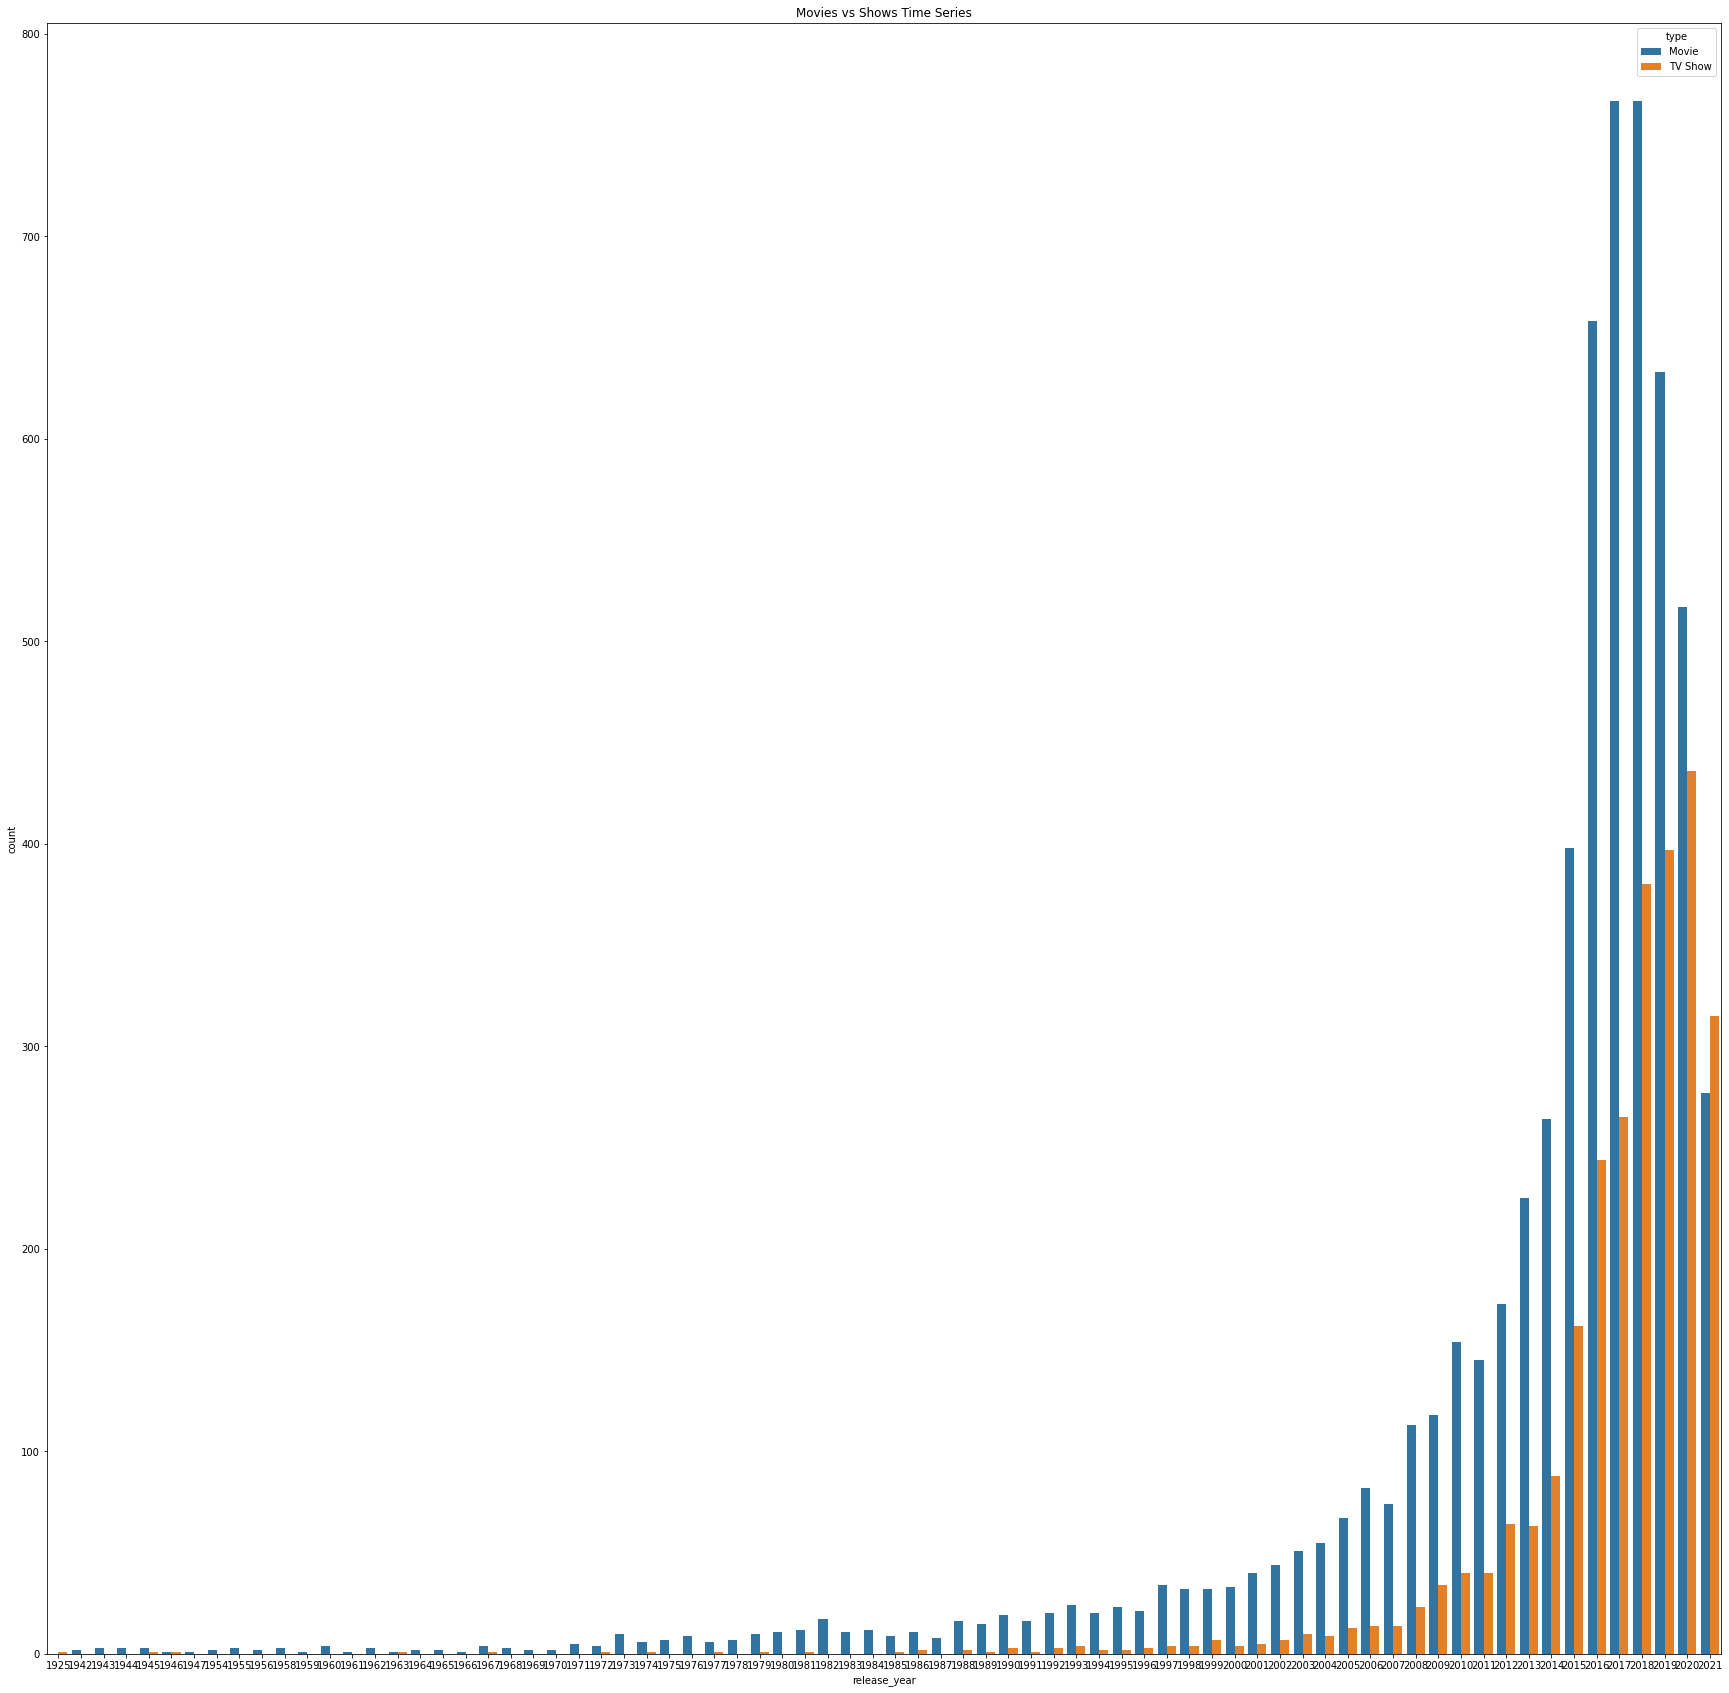

In [50]:
plt.figure(figsize=(30,30))
sns.countplot(data = df, x = "release_year",hue = "type" )
plt.title("Movies vs Shows Time Series")

Exponential growth in movies and series as expected, with Tv shows being slightly more recent

In [51]:
df.country.value_counts()

United States                             2818
India                                      972
United Kingdom                             419
Japan                                      245
South Korea                                199
                                          ... 
Romania, Bulgaria, Hungary                   1
Uruguay, Guatemala                           1
France, Senegal, Belgium                     1
Mexico, United States, Spain, Colombia       1
United Arab Emirates, Jordan                 1
Name: country, Length: 748, dtype: int64

USA producing by far the most movies with India coming second

<AxesSubplot:xlabel='rating', ylabel='count'>

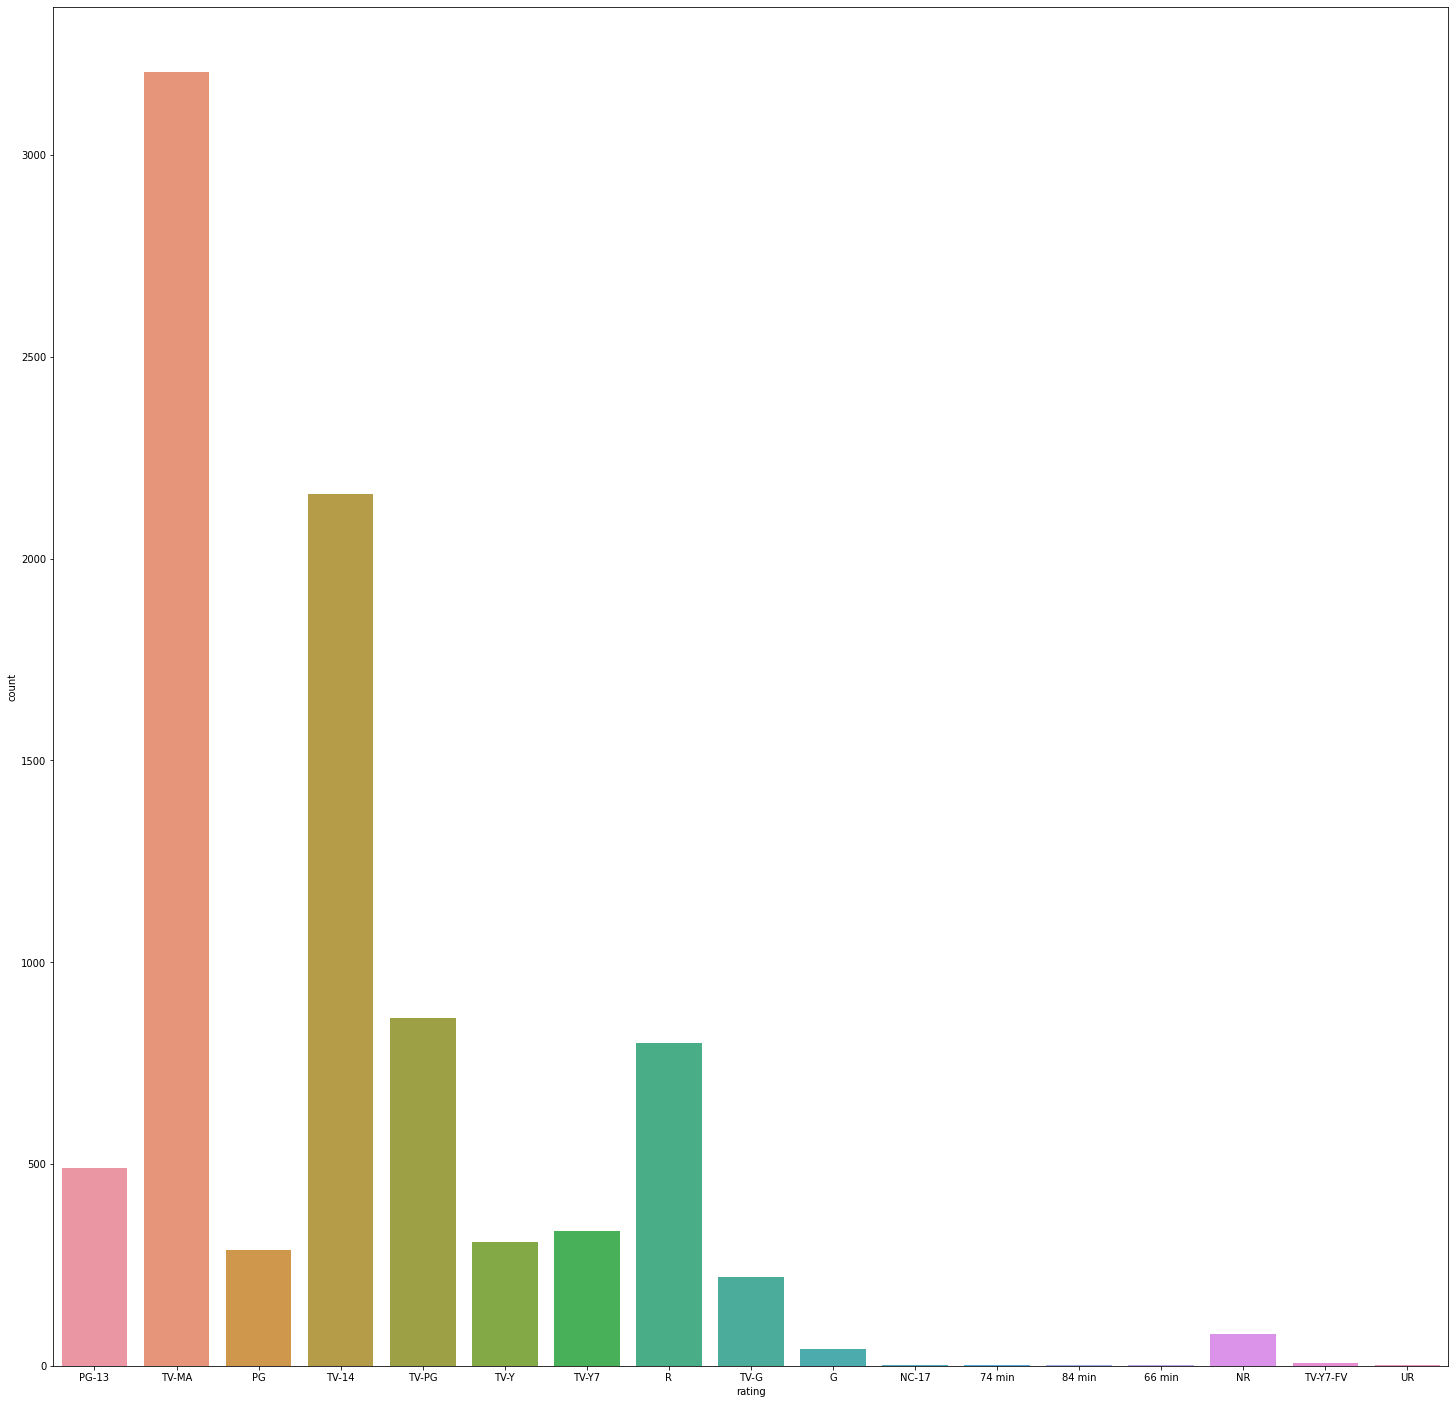

In [52]:
plt.figure(figsize=(25,25))
sns.countplot(data = df, x = "rating" )

In [53]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [54]:
df = df.drop("date_added",axis=1)
df = df.drop("show_id",axis=1)
df = df.drop("rating",axis=1)
df = df.drop("duration",axis=1)

Removed features which either add no further information for user preferences 

**Converting all the strings to lower case for when the text is tokenized/vectorized**

In [55]:
def converter(df):
    for i in (df.columns):
        df[i] = df[i].astype(str)
        df[i]= df[i].str.lower()
    return df    
converter(df)

,type,title,director,cast,country,release_year,listed_in,description
0,movie,dick johnson is dead,kirsten johnson,nan,united states,2020,documentaries,"as her father nears the end of his life, filmm..."
1,tv show,blood & water,nan,"ama qamata, khosi ngema, gail mabalane, thaban...",south africa,2021,"international tv shows, tv dramas, tv mysteries","after crossing paths at a party, a cape town t..."
2,tv show,ganglands,julien leclercq,"sami bouajila, tracy gotoas, samuel jouy, nabi...",nan,2021,"crime tv shows, international tv shows, tv act...",to protect his family from a powerful drug lor...
3,tv show,jailbirds new orleans,nan,nan,nan,2021,"docuseries, reality tv","feuds, flirtations and toilet talk go down amo..."
4,tv show,kota factory,nan,"mayur more, jitendra kumar, ranjan raj, alam k...",india,2021,"international tv shows, romantic tv shows, tv ...",in a city of coaching centers known to train i...
...,...,...,...,...,...,...,...,...
8802,movie,zodiac,david fincher,"mark ruffalo, jake gyllenhaal, robert downey j...",united states,2007,"cult movies, dramas, thrillers","a political cartoonist, a crime reporter and a..."
8803,tv show,zombie dumb,nan,nan,nan,2018,"kids' tv, korean tv shows, tv comedies","while living alone in a spooky town, a young g..."
8804,movie,zombieland,ruben fleischer,"jesse eisenberg, woody harrelson, emma stone, ...",united states,2009,"comedies, horror movies",looking to survive in a world taken over by zo...
8805,movie,zoom,peter hewitt,"tim allen, courteney cox, chevy chase, kate ma...",united states,2006,"children & family movies, comedies","dragged from civilian life, a former superhero..."


Here I create a new column in the dataframe to store all the descriptive columns so I that  can vectorize them all together.

In [56]:
df["descriptor"] = ""
def merger(x):
    for i in x.columns:
        df["descriptor"] += df[i]+" " 
        
    return df["descriptor"]
merger(df.drop("title",axis=1))

0       movie kirsten johnson nan united states 2020 d...
1       tv show nan ama qamata, khosi ngema, gail maba...
2       tv show julien leclercq sami bouajila, tracy g...
3       tv show nan nan nan 2021 docuseries, reality t...
4       tv show nan mayur more, jitendra kumar, ranjan...
                              ...                        
8802    movie david fincher mark ruffalo, jake gyllenh...
8803    tv show nan nan nan 2018 kids' tv, korean tv s...
8804    movie ruben fleischer jesse eisenberg, woody h...
8805    movie peter hewitt tim allen, courteney cox, c...
8806    movie mozez singh vicky kaushal, sarah-jane di...
Name: descriptor, Length: 8807, dtype: object

In [57]:
df.head()

,type,title,director,cast,country,release_year,listed_in,description,descriptor
0,movie,dick johnson is dead,kirsten johnson,nan,united states,2020,documentaries,"as her father nears the end of his life, filmm...",movie kirsten johnson nan united states 2020 d...
1,tv show,blood & water,nan,"ama qamata, khosi ngema, gail mabalane, thaban...",south africa,2021,"international tv shows, tv dramas, tv mysteries","after crossing paths at a party, a cape town t...","tv show nan ama qamata, khosi ngema, gail maba..."
2,tv show,ganglands,julien leclercq,"sami bouajila, tracy gotoas, samuel jouy, nabi...",nan,2021,"crime tv shows, international tv shows, tv act...",to protect his family from a powerful drug lor...,"tv show julien leclercq sami bouajila, tracy g..."
3,tv show,jailbirds new orleans,nan,nan,nan,2021,"docuseries, reality tv","feuds, flirtations and toilet talk go down amo...","tv show nan nan nan 2021 docuseries, reality t..."
4,tv show,kota factory,nan,"mayur more, jitendra kumar, ranjan raj, alam k...",india,2021,"international tv shows, romantic tv shows, tv ...",in a city of coaching centers known to train i...,"tv show nan mayur more, jitendra kumar, ranjan..."


In [58]:
x = pd.DataFrame(df.title)
x["descriptor"] = df["descriptor"].astype(str)
x.head()

,title,descriptor
0,dick johnson is dead,movie kirsten johnson nan united states 2020 d...
1,blood & water,"tv show nan ama qamata, khosi ngema, gail maba..."
2,ganglands,"tv show julien leclercq sami bouajila, tracy g..."
3,jailbirds new orleans,"tv show nan nan nan 2021 docuseries, reality t..."
4,kota factory,"tv show nan mayur more, jitendra kumar, ranjan..."


In [59]:

x["descriptor"] = x["descriptor"].str.replace("nan","")
x["descriptor"] = x["descriptor"].str.replace(",","")
x

,title,descriptor
0,dick johnson is dead,movie kirsten johnson united states 2020 docu...
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...
2,ganglands,tv show julien leclercq sami bouajila tracy go...
3,jailbirds new orleans,tv show 2021 docuseries reality tv feuds fl...
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...
...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...
8803,zombie dumb,tv show 2018 kids' tv korean tv shows tv co...
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...
8805,zoom,movie peter hewitt tim allen courteney cox che...


In [60]:
x["descriptor"]= x["descriptor"].astype(str)

In [61]:
x["descriptor"].dtype

dtype('O')

In [62]:
import nltk
from nltk.tokenize import word_tokenize

In [63]:
x['tokenized_desc'] = x['descriptor'].apply(lambda x:"".join(x))

In [64]:
x

,title,descriptor,tokenized_desc
0,dick johnson is dead,movie kirsten johnson united states 2020 docu...,movie kirsten johnson united states 2020 docu...
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...,tv show ama qamata khosi ngema gail mabalane ...
2,ganglands,tv show julien leclercq sami bouajila tracy go...,tv show julien leclercq sami bouajila tracy go...
3,jailbirds new orleans,tv show 2021 docuseries reality tv feuds fl...,tv show 2021 docuseries reality tv feuds fl...
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...,tv show mayur more jitendra kumar ranjan raj ...
...,...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...,movie david fincher mark ruffalo jake gyllenha...
8803,zombie dumb,tv show 2018 kids' tv korean tv shows tv co...,tv show 2018 kids' tv korean tv shows tv co...
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...,movie ruben fleischer jesse eisenberg woody ha...
8805,zoom,movie peter hewitt tim allen courteney cox che...,movie peter hewitt tim allen courteney cox che...


In [65]:
x["tokenized_desc"]= x["tokenized_desc"].astype(str)


In [66]:
x

,title,descriptor,tokenized_desc
0,dick johnson is dead,movie kirsten johnson united states 2020 docu...,movie kirsten johnson united states 2020 docu...
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...,tv show ama qamata khosi ngema gail mabalane ...
2,ganglands,tv show julien leclercq sami bouajila tracy go...,tv show julien leclercq sami bouajila tracy go...
3,jailbirds new orleans,tv show 2021 docuseries reality tv feuds fl...,tv show 2021 docuseries reality tv feuds fl...
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...,tv show mayur more jitendra kumar ranjan raj ...
...,...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...,movie david fincher mark ruffalo jake gyllenha...
8803,zombie dumb,tv show 2018 kids' tv korean tv shows tv co...,tv show 2018 kids' tv korean tv shows tv co...
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...,movie ruben fleischer jesse eisenberg woody ha...
8805,zoom,movie peter hewitt tim allen courteney cox che...,movie peter hewitt tim allen courteney cox che...


Used CV to vectorize my words into numbers/vectors so that we can compare vector to vector

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 5000, stop_words = "english",token_pattern=r"\b\w+\b")
cv.fit_transform(x["tokenized_desc"])
matrix = cv.fit_transform(x["tokenized_desc"])

In [68]:
x

,title,descriptor,tokenized_desc
0,dick johnson is dead,movie kirsten johnson united states 2020 docu...,movie kirsten johnson united states 2020 docu...
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...,tv show ama qamata khosi ngema gail mabalane ...
2,ganglands,tv show julien leclercq sami bouajila tracy go...,tv show julien leclercq sami bouajila tracy go...
3,jailbirds new orleans,tv show 2021 docuseries reality tv feuds fl...,tv show 2021 docuseries reality tv feuds fl...
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...,tv show mayur more jitendra kumar ranjan raj ...
...,...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...,movie david fincher mark ruffalo jake gyllenha...
8803,zombie dumb,tv show 2018 kids' tv korean tv shows tv co...,tv show 2018 kids' tv korean tv shows tv co...
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...,movie ruben fleischer jesse eisenberg woody ha...
8805,zoom,movie peter hewitt tim allen courteney cox che...,movie peter hewitt tim allen courteney cox che...


In [69]:
x.index.name = "index"

In [70]:
x

,title,descriptor,tokenized_desc
index,,,
0,dick johnson is dead,movie kirsten johnson united states 2020 docu...,movie kirsten johnson united states 2020 docu...
1,blood & water,tv show ama qamata khosi ngema gail mabalane ...,tv show ama qamata khosi ngema gail mabalane ...
2,ganglands,tv show julien leclercq sami bouajila tracy go...,tv show julien leclercq sami bouajila tracy go...
3,jailbirds new orleans,tv show 2021 docuseries reality tv feuds fl...,tv show 2021 docuseries reality tv feuds fl...
4,kota factory,tv show mayur more jitendra kumar ranjan raj ...,tv show mayur more jitendra kumar ranjan raj ...
...,...,...,...
8802,zodiac,movie david fincher mark ruffalo jake gyllenha...,movie david fincher mark ruffalo jake gyllenha...
8803,zombie dumb,tv show 2018 kids' tv korean tv shows tv co...,tv show 2018 kids' tv korean tv shows tv co...
8804,zombieland,movie ruben fleischer jesse eisenberg woody ha...,movie ruben fleischer jesse eisenberg woody ha...


Here I used cosine similarity, which simply calculates the angle between vectors allowing us to see similar vectors 

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(matrix)

In [72]:
matrix

<8807x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 227626 stored elements in Compressed Sparse Row format>

In this final section I take an input for movie which is then passed through the function which finds the index of the movie which is then used to find similar vectors, which are then sorted in descending order

In [73]:
def index_title(user_movie):
    movie_index =  x[x["title"] == user_movie]["title"].index[0]
    movies_list = sorted(list(enumerate(similarity_matrix[movie_index])), key=lambda x:x[1], reverse=True)[1:7]
    Recommendations = []
  
    for movie in movies_list:
        Recommendations.append(x.iloc[movie[0]].title)
    return Recommendations

index_title("grown ups")

['hubie halloween',
 'sandy wexler',
 'the wrong missy',
 "you don't mess with the zohan",
 '50 first dates',
 'big daddy']